In [1]:
import pandas as pd
import scipy 
import numpy as np
import seaborn as sns
# inference library
import pymc3 as pm
import theano.tensor as tt

from utils.generators import UserGenerator

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# A simple generator to simulate userdata
ug = UserGenerator(column_label='Clickthrough Rate')

In [3]:
# creating a dataframe prelabeled for AB testing
# the outcome will contain 2 groups, A with a success rate of 12% B with a success rate of 10 % . 
df = ug.generate_ab_split_df(nr_of_users=4000,positive_ratio_A=0.12, positive_ratio_B=0.1, nr_of_days=5,AB_user_ratio=0.5)

In [6]:
df.sample(10)

,user_id,Clickthrough Rate,datetime,group
3027,uid_4545,0,2020-01-04 10:27:06,B
1875,uid_3393,0,2020-01-03 21:01:56,A
21,uid_1539,0,2020-01-03 04:27:31,A
339,uid_1857,0,2020-01-05 11:02:59,A
2776,uid_4294,1,2020-01-01 09:06:25,B
3154,uid_4672,0,2020-01-02 11:58:43,B
585,uid_2103,1,2020-01-03 11:52:55,A
2037,uid_3555,0,2020-01-03 23:02:16,B
3965,uid_5483,0,2020-01-03 20:52:37,B
1130,uid_2648,0,2020-01-05 14:09:52,A


In [7]:

with pm.Model() as model:
    
    # sample size
    n_A = df.loc[df.group=='A'].shape[0]
    n_B = df.loc[df.group=='A'].shape[1]
    
    # priors for the probabilities.  Beta of alpha1 and beta1 is a Uniform distribtion
    p_A = pm.Beta("p_A", alpha=1, beta=1 )
    p_B = pm.Beta("p_B", alpha=1, beta=1 )
   
    # observed data is Binomial
    obs_A = pm.Binomial("A", n=n_A ,p=p_A, observed=df.loc[df.group=='A']['Clickthrough Rate'].sum())
    obs_B = pm.Binomial("B", n=n_B ,p=p_B, observed=df.loc[df.group=='B']['Clickthrough Rate'].sum())
    
    # The delta is Deterministic
    delta = pm.Deterministic("delta", p_A - p_B)
    
    # an initiator
    start = pm.find_MAP()
    
    # this is the recommended sampler
    step = pm.NUTS()
    
    # a trace.  A list of observations made by the MCMC sampler
    trace = pm.sample(10000, tune=5000,step=step)
    
    # Drop the first 5000 samples, as the later ones are more trustworthy, since the sampler more likly converged
    burned_trace = trace[5000:]

logp = -1,419.4, ||grad|| = 1,111.3: 100%|██████████| 10/10 [00:00<00:00, 4391.48it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_B, p_A]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:07<00:00, 8423.28draws/s]


In [8]:
# informative priors
# True means
p_a = df.loc[df.group == 'A']['Clickthrough Rate'].mean()
p_b = df.loc[df.group == 'B']['Clickthrough Rate'].mean()

In [9]:
trace.varnames

['p_A_logodds__', 'p_B_logodds__', 'p_A', 'p_B', 'delta']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37c6968978>,
      dtype=object)

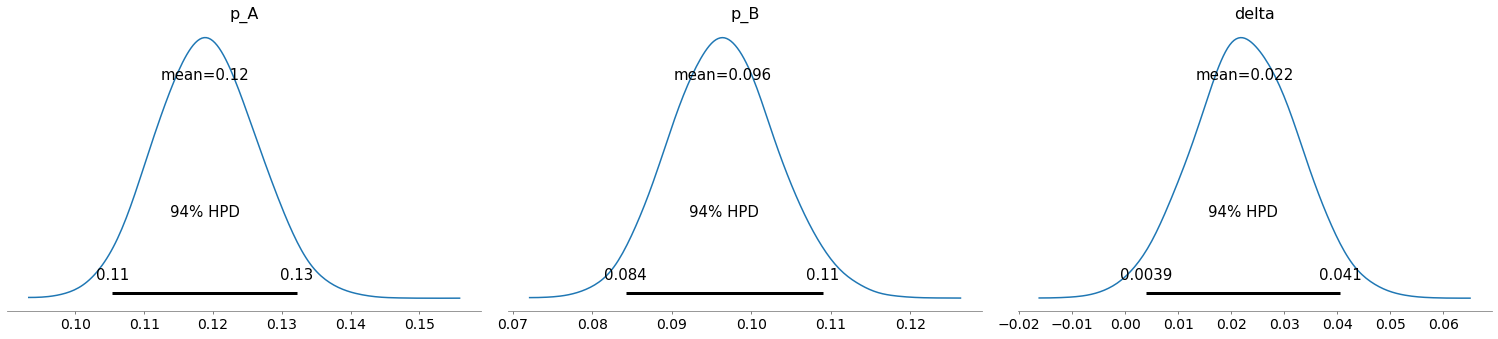

In [10]:
pm.plot_posterior(burned_trace )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37c407f0b8>],
      dtype=object)

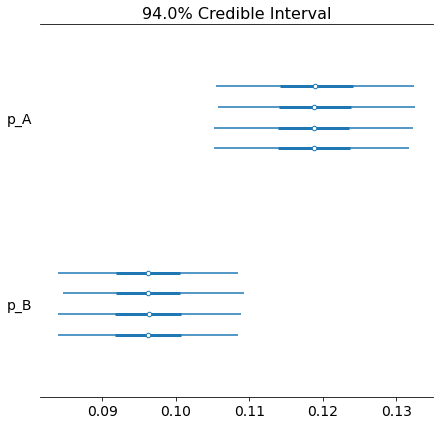

In [15]:
pm.forestplot(trace, var_names=['p_A','p_B'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37b72e5550>],
      dtype=object)

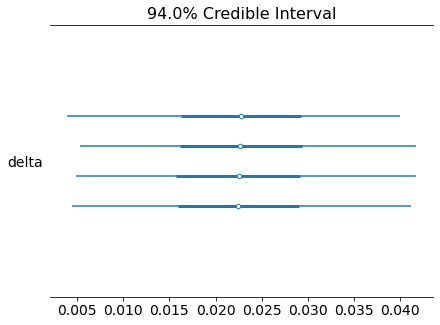

In [16]:
pm.forestplot(trace, var_names=['delta'])

[Text(0, 0.5, 'Häufigkeit im posterior'), Text(0.5, 0, 'Erfolgsrate')]

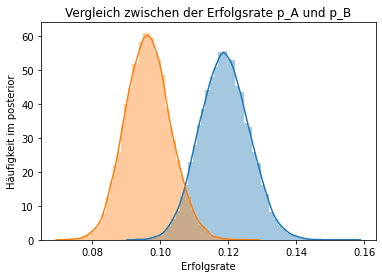

In [12]:

ax = sns.distplot(burned_trace['p_A'])

ax = sns.distplot(burned_trace['p_B'])

ax.set_title("Vergleich zwischen der Erfolgsrate p_A und p_B")
ax.set(xlabel='Erfolgsrate', ylabel='Häufigkeit im posterior')

[Text(0, 0.5, 'Häufigkeit im posterior'), Text(0.5, 0, 'Delta Erfolgsrate')]

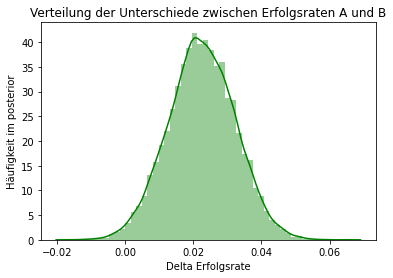

In [13]:
ax = sns.distplot(burned_trace['delta'], color='g')
ax.set_title('Verteilung der Unterschiede zwischen Erfolgsraten A und B')
ax.set(xlabel='Delta Erfolgsrate', ylabel='Häufigkeit im posterior')

In [14]:
burned_trace['delta'].mean(), burned_trace['delta'].std()

(0.022491673021234452, 0.009755877646811673)